# Notebook para Análisis de Precios de Toyota Corolla

## Configuración y Carga de Datos



In [66]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import joblib

In [67]:
# Configuración de MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("toyota_parcial")

<Experiment: artifact_location='mlflow-artifacts:/576424483513881687', creation_time=1747861702848, experiment_id='576424483513881687', last_update_time=1747861702848, lifecycle_stage='active', name='toyota_parcial', tags={}>

In [68]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)

## Limpieza de datos

In [69]:
# # Corregir la variable Doors y eliminar observaciones incorrectas
# print("\nDistribución original de Doors:")
# print(df['Doors'].value_counts())

# # Eliminar coches con 2 puertas (observaciones probablemente erróneas)
# df = df[df['Doors'] != 2]

# # Corregir coches con 4 puertas (4 laterales → 5 contando el maletero)
# df.loc[df['Doors'] == 4, 'Doors'] = 5

# print("\nDistribución corregida de Doors:")
# print(df['Doors'].value_counts())








## Exploración de Datos (EDA)



In [70]:
# Dimensiones del dataset
df.shape

(1436, 37)

In [71]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [72]:
# Estadísticas descriptivas
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
# Lista de columnas
print(df.columns.tolist())

['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Tow_Bar']


In [74]:
# Verificación de valores nulos
df.isnull().sum()

Id                  0
Model               0
Price               0
Age_08_04           0
Mfg_Month           0
Mfg_Year            0
KM                  0
Fuel_Type           0
HP                  0
Met_Color           0
Automatic           0
cc                  0
Doors               0
Cylinders           0
Gears               0
Quarterly_Tax       0
Weight              0
Mfr_Guarantee       0
BOVAG_Guarantee     0
Guarantee_Period    0
ABS                 0
Airbag_1            0
Airbag_2            0
Airco               0
Automatic_airco     0
Boardcomputer       0
CD_Player           0
Central_Lock        0
Powered_Windows     0
Power_Steering      0
Radio               0
Mistlamps           0
Sport_Model         0
Backseat_Divider    0
Metallic_Rim        0
Radio_cassette      0
Tow_Bar             0
dtype: int64

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7316\3039655210.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Fuel_Type", palette="pastel")


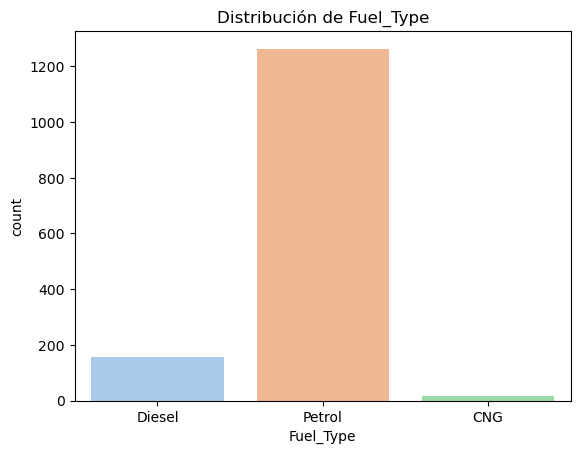

In [75]:
# Análisis de variables categóricas
sns.countplot(data=df, x="Fuel_Type", palette="pastel")
plt.title("Distribución de Fuel_Type")
plt.show()

In [76]:
# Búsqueda de duplicados
def find_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifica filas duplicadas completas en el DataFrame.
    """
    mask = df.duplicated(keep='first')
    duplicates = df[mask].copy()
    return duplicates

duplicates = find_duplicates(df)
print(f"Número de filas duplicadas: {len(duplicates)}")
if len(duplicates) > 0:
    print("Filas duplicadas:")
    print(duplicates)

Número de filas duplicadas: 0


In [77]:
# Generamos matriz de correlación para el análisis exploratorio
corr = df.select_dtypes(include=['number']).corr()

# Top correlaciones con Price
top_vars = (corr['Price']
            .abs()
            .sort_values(ascending=False)
            .head(11))   # Price + 10 más altas

print("Variables más correlacionadas con Price:")
print(top_vars)

Variables más correlacionadas con Price:
Price              1.000000
Mfg_Year           0.885159
Age_08_04          0.876590
Id                 0.738250
Boardcomputer      0.601292
Automatic_airco    0.588262
Weight             0.581198
KM                 0.569960
CD_Player          0.481374
Airco              0.429259
Powered_Windows    0.356518
Name: Price, dtype: float64


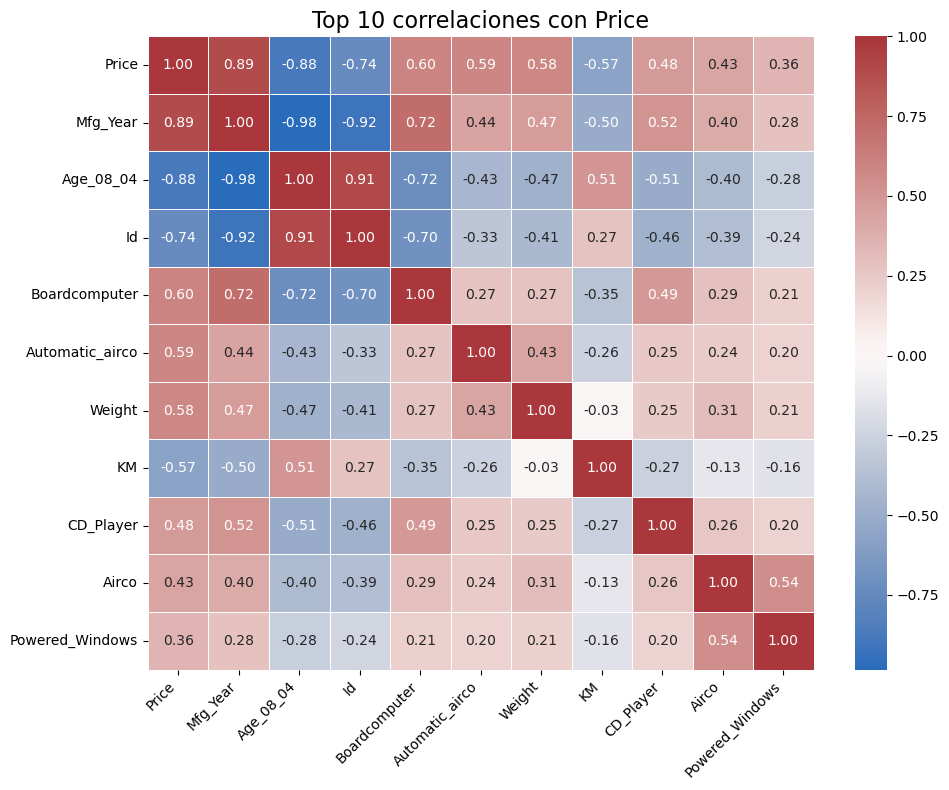

In [78]:
# Visualización de correlaciones principales
top_vars_idx = top_vars.index
sub_corr = corr.loc[top_vars_idx, top_vars_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(
    sub_corr,
    cmap="vlag",
    annot=True,
    fmt=".2f",
    linewidths=.5,
    center=0
)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 correlaciones con Price", fontsize=16)
plt.tight_layout()
plt.show()

In [79]:
# Detección de outliers
def detect_outliers(df):
    cols = df.select_dtypes(include=np.number).columns
    outliers = pd.DataFrame(columns=['Feature', 'Number of Outliers'])
    
    for column in cols:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - (1.5*iqr)
        fence_high = q3 + (1.5*iqr)
        outliers_count = df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
        
        outliers = pd.concat([outliers, pd.DataFrame({
            'Feature': [column], 
            'Number of Outliers': [outliers_count]
        })], ignore_index=True)
    
    return outliers.sort_values('Number of Outliers', ascending=False)

outlier_analysis = detect_outliers(df)
outlier_analysis

,Feature,Number of Outliers
31,Backseat_Divider,330
24,CD_Player,314
32,Metallic_Rim,294
18,ABS,268
13,Quarterly_Tax,224
28,Radio,210
33,Radio_cassette,209
17,Guarantee_Period,162
16,BOVAG_Guarantee,150
9,cc,123






















## Preprocesamiento y Feature Engineering



In [80]:
# Separar X (predictores) e y (variable objetivo)
X = df.drop("Price", axis=1)
y = df["Price"]

# Eliminar columnas no relevantes para el modelo
X = df.drop(["Price", "Model", "Cylinders", "Id", "Radio_cassette", "BOVAG_Guarantee",
             "Backseat_Divider", "Mfg_Month","Mfg_Year", "Automatic", "Central_Lock",
             "Met_Color", "Mfr_Guarantee", "Guarantee_Period", "Gears", "Radio", "Power_Steering",
             "Metallic_Rim", "Tow_Bar", "Sport_Model"], axis=1)

print("Variables conservadas:")
print(X.columns.tolist())

Variables conservadas:
['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'cc', 'Doors', 'Quarterly_Tax', 'Weight', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Powered_Windows', 'Mistlamps']


In [81]:
# Feature Engineering
# Combinar airbags en una sola variable
X["Airbag_Count"] = df["Airbag_1"].fillna(0) + df["Airbag_2"].fillna(0)
X.drop(["Airbag_1", "Airbag_2"], axis=1, inplace=True)

# Codificación de variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Forzar tipos numéricos
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Eliminar filas con NaNs
combined = pd.concat([X, y], axis=1).dropna()
X = combined.drop("Price", axis=1)
y = combined["Price"]

# Convertir a float y agregar constante para OLS
X = X.astype(float)
y = y.astype(float)
X = sm.add_constant(X)

# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1
)

print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")

Dimensiones de X_train: (861, 18), X_test: (575, 18)






## Selección de Características con Lasso



In [82]:
# Lasso Regression
from sklearn.linear_model import LassoCV

# Quitar constante para Lasso
X_train_lasso = X_train.drop("const", axis=1)
X_test_lasso = X_test.drop("const", axis=1)

# Entrenamiento con validación cruzada
lasso = LassoCV(cv=5, random_state=1)
lasso.fit(X_train_lasso, y_train)

# Predicciones y métricas
y_pred_lasso = lasso.predict(X_test_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Alpha óptimo: {lasso.alpha_:.6f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"MAE: {mae_lasso:.2f}")
print(f"R²: {r2_lasso:.4f}")

# Variables seleccionadas
lasso_features = X_train_lasso.columns[lasso.coef_ != 0]
print(f"\nFeatures seleccionadas por Lasso ({len(lasso_features)}/{X_train_lasso.shape[1]}):")
print(lasso_features.tolist())

Alpha óptimo: 79604.020831
RMSE: 3910.75
MAE: 2142.13
R²: -0.2482

Features seleccionadas por Lasso (3/17):
['KM', 'cc', 'Weight']




## Reducción de Dimensionalidad con PCA



In [83]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

# PCA
pca = PCA(n_components=0.95, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Número de componentes PCA (95% varianza): {pca.n_components_}")

# Modelo con PCA
lasso_pca = LassoCV(cv=5, random_state=1)
lasso_pca.fit(X_train_pca, y_train)
y_pred_pca = lasso_pca.predict(X_test_pca)

# Evaluación
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)

print(f"RMSE: {rmse_pca:.2f}")
print(f"R²: {r2_pca:.4f}")

Número de componentes PCA (95% varianza): 12
RMSE: 1326.77
R²: 0.8563




## Modelo de Regresión Lineal (OLS)



In [84]:
import mlflow
if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="ols_model_run"):
    # 9. Ajuste OLS
    model   = sm.OLS(y_train, X_train)
    results = model.fit()

    # 10. Predicción
    y_pred = results.predict(X_test)

    from sklearn.metrics import root_mean_squared_error


    # 11. Métricas
    rmse       = root_mean_squared_error(y_test, y_pred)
    mae        = mean_absolute_error(y_test, y_pred)
    r2_sklearn = r2_score(y_test, y_pred)
    r2_sm      = results.rsquared
    adj_r2     = results.rsquared_adj
    aic        = results.aic
    bic        = results.bic

    # Logging de métricas a MLflow (asegúrate que sean float)
    mlflow.log_metric("rmse", float(rmse))
    mlflow.log_metric("mae", float(mae))
    mlflow.log_metric("r2_sklearn", float(r2_sklearn))
    mlflow.log_metric("r2_statsmodels", float(r2_sm))
    mlflow.log_metric("adj_r2", float(adj_r2))
    mlflow.log_metric("aic", float(aic))
    mlflow.log_metric("bic", float(bic))
    mlflow.log_metric("n_features", int(X_train.shape[1]))
    

    # 12. Carpeta de artefactos
    os.makedirs("mlartifacts", exist_ok=True)

    # 15. Summary de OLS
    summary_path = os.path.join("mlartifacts", "ols_summary.txt")
    with open(summary_path, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_path)

    # 16. Serializar modelo
    model_pkl = os.path.join("mlartifacts", "ols_model.pkl")
    joblib.dump(results, model_pkl)
    mlflow.log_artifact(model_pkl)

    # Guardar nombres de features
    features_path = os.path.join("mlartifacts", "features.txt")
    with open(features_path, "w") as f:
        f.write("\n".join(X.columns))
    mlflow.log_artifact(features_path)

    # =======================
    # VIF ANALYSIS
    # =======================

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

    vif_path = os.path.join("mlartifacts", "vif_report.csv")
    vif_data.to_csv(vif_path, index=False)
    mlflow.log_artifact(vif_path)

    # =======================
    # GRÁFICOS
    # =======================

    # Plot: Real vs. Predicho
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price")
    plt.grid(True)
    real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
    plt.savefig(real_vs_pred_path)
    mlflow.log_artifact(real_vs_pred_path)
    plt.close()

    # Plot: Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
    plt.savefig(residuals_path)
    mlflow.log_artifact(residuals_path)
    plt.close()

    # =======================
    # MATRIZ DE CORRELACIÓN
    # =======================

    plt.figure(figsize=(16, 12))
    corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"shrink": 0.75},
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title("Correlation Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    corr_matrix_path = os.path.join("mlartifacts", "correlation_matrix.png")
    plt.tight_layout()
    plt.savefig(corr_matrix_path)
    mlflow.log_artifact(corr_matrix_path)
    plt.close()

    # # =======================
    # # SCATTER MATRIX (FULL PAIR PLOT)
    # # =======================
    # # Combina X_train y y_train para el pairplot
    # df_pairs = pd.concat([X_train, y_train.rename("target")], axis=1)

    # # Opcional: muestrea hasta 500 filas para no saturar la gráfica
    # df_pairs_sample = df_pairs.sample(n=min(len(df_pairs), 500), random_state=1)

    # # Usa Seaborn PairGrid para trazar cada par de variables
    # g = sns.PairGrid(df_pairs_sample, diag_sharey=False, height=2.5)
    # g.map_upper(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
    # g.map_lower(sns.scatterplot, s=15, edgecolor="w", alpha=0.6)
    # g.map_diag(sns.histplot, kde=True)
    # plt.suptitle("Scatter Matrix Completa de Features y Target", y=1.02)

    # scatter_matrix_path = os.path.join("mlartifacts", "scatter_matrix.png")
    # g.fig.savefig(scatter_matrix_path)
    # mlflow.log_artifact(scatter_matrix_path)
    # plt.close()
    

    print("Modelo OLS registrado con MLflow.")

Modelo OLS registrado con MLflow.
🏃 View run ols_model_run at: http://localhost:5000/#/experiments/576424483513881687/runs/19a7328a99884087aac38a27a1aacdb3
🧪 View experiment at: http://localhost:5000/#/experiments/576424483513881687




## Análisis de Multicolinealidad



In [85]:
# Análisis VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                  for i in range(X_train.shape[1])]
    
# Ordenar por VIF descendente
vif_data = vif_data.sort_values("VIF", ascending=False)

print("Análisis de Factor de Inflación de Varianza (VIF):")
print("Un VIF > 10 indica alta multicolinealidad")
print(vif_data)

# Guardar resultados
vif_path = os.path.join("mlartifacts", "vif_report.csv")
vif_data.to_csv(vif_path, index=False)
mlflow.log_artifact(vif_path)

Análisis de Factor de Inflación de Varianza (VIF):
Un VIF > 10 indica alta multicolinealidad
             feature          VIF
0              const  1319.176560
16  Fuel_Type_Diesel    22.596587
17  Fuel_Type_Petrol    13.927617
4                 cc     9.247798
3                 HP     6.109469
6      Quarterly_Tax     4.693579
1          Age_08_04     4.306410
7             Weight     3.269492
11     Boardcomputer     2.425628
15      Airbag_Count     2.212789
2                 KM     2.061095
8                ABS     2.039028
9              Airco     1.769874
13   Powered_Windows     1.701657
14         Mistlamps     1.674660
10   Automatic_airco     1.604326
12         CD_Player     1.485846
5              Doors     1.221598




## Visualización de Resultados



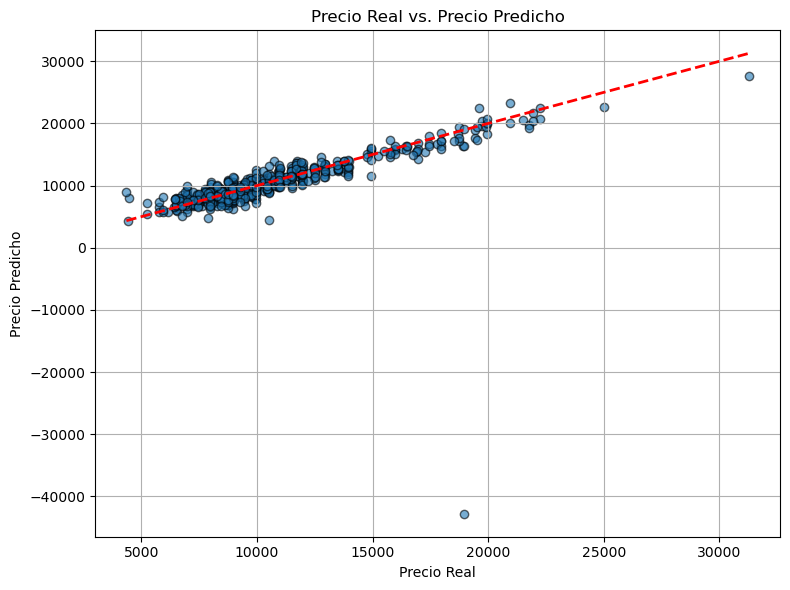

In [86]:
# Plot: Real vs. Predicho
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Precio Real vs. Precio Predicho")
plt.grid(True)
plt.tight_layout()

real_vs_pred_path = os.path.join("mlartifacts", "actual_vs_predicted.png")
plt.savefig(real_vs_pred_path)
mlflow.log_artifact(real_vs_pred_path)
plt.show()

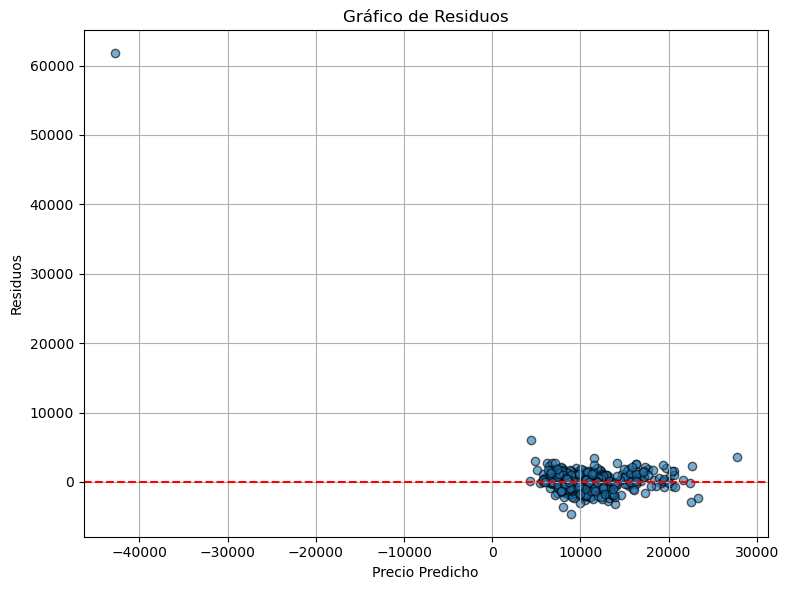

In [87]:
# Análisis de residuos
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Precio Predicho")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.grid(True)
plt.tight_layout()

residuals_path = os.path.join("mlartifacts", "residuals_plot.png")
plt.savefig(residuals_path)
mlflow.log_artifact(residuals_path)
plt.show()

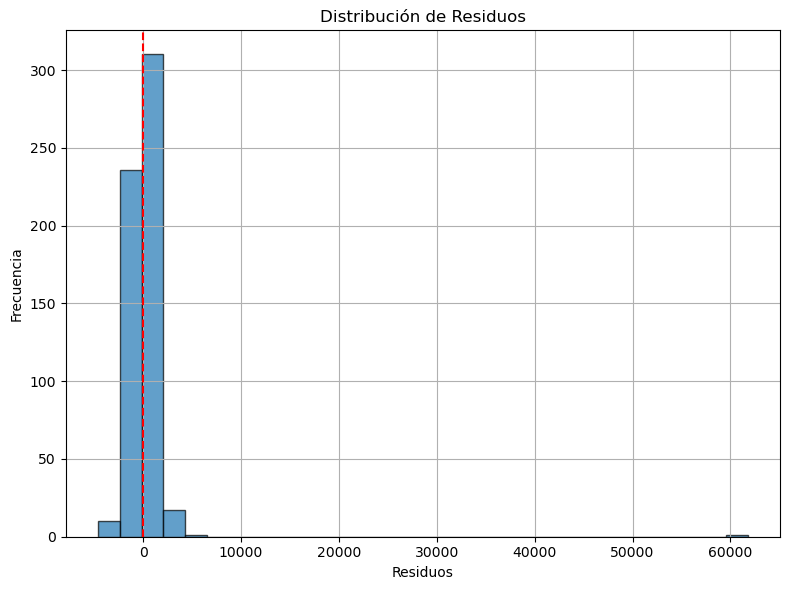

In [88]:
# Histograma de residuos
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()







## Comparativa de Modelos



In [89]:
# Crear tabla comparativa
results_df = pd.DataFrame({
    "Modelo": ["OLS", "Lasso", "Lasso+PCA"],
    "RMSE": [rmse, rmse_lasso, rmse_pca],
    "MAE": [mae, mae_lasso, mean_absolute_error(y_test, y_pred_pca)],
    "R²": [r2_sklearn, r2_lasso, r2_pca],
    "Num. Features": [X_train.shape[1], len(lasso_features), pca.n_components_]
})

print("Comparativa de modelos:")
print(results_df)

Comparativa de modelos:
      Modelo         RMSE          MAE        R²  Num. Features
0        OLS  2815.471073   981.796605  0.353060             18
1      Lasso  3910.746720  2142.131645 -0.248191              3
2  Lasso+PCA  1326.769137  1014.237184  0.856335             12
